**Case Study in Econometrics and Data Science** @ Vrije Universiteit Amsterdam

Code appendix: Impact of Bandwidth Choice on Time-Varying Model Averaging Forecasting Performance

Students of Group 9:
A.V. Rodriguez, 2903029
S.E. Jeong, 2894452
M.J.M. Laarhoven, 2767053
N.C.E. Zloch, 2972796

# Part I. Code replication

Packages and data load

In [1]:
# %pip install numpy pandas matplotlib scipy tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

np.random.seed(2026)

In [2]:
# global parameters
ch_opt =2.34
R2_grid = np.arange(0.1, 1.0, 0.1)

Model

In [3]:
def DGP1(T, J, R2, alpha=1.5):
    c = np.sqrt(R2 / (1 - R2))

    t = np.arange(1, T + 1)
    tau = t / T
    F_tau = tau**3

    X = np.random.randn(T, J)
    X[:, 0] = 1.0
    j = np.arange(1, J+1)
    theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))
    mu = F_tau * (X @ theta)
    eps = np.random.randn(T)
    Y = mu + eps

    return Y, X, mu

def DGP2(T, J, R2, alpha=1.5):
    c = np.sqrt(R2 / (1 - R2))

    t = np.arange(1, T + 1)
    tau = t / T

    F_tau = np.where(tau < 0.3, 0.1,
                     np.where(tau < 0.8, 1.0, -0.5))

    X = np.random.randn(T, J)
    X[:, 0] = 1.0

    j = np.arange(1, J+1)
    theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))

    mu = F_tau * (X @ theta)
    eps = np.random.randn(T)

    Y = mu + eps
    return Y, X, mu

In [59]:
y1, _,mu1  = DGP1(200, 100, 0.5)

In [60]:
y2, _, mu2  = DGP2(200, 100, 0.5)

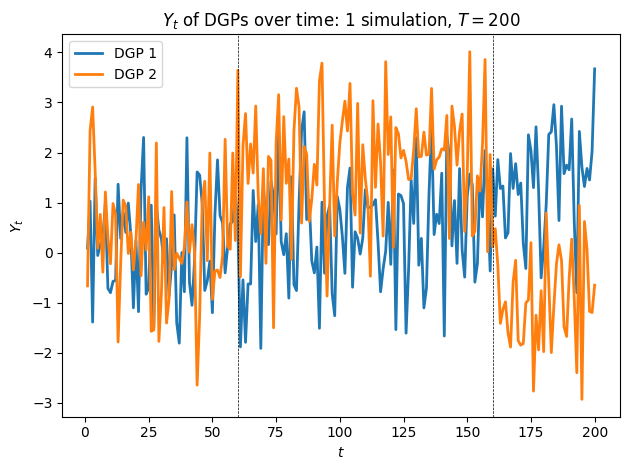

In [99]:
T = 200
plt.plot(np.arange(1, T + 1), y1, linewidth=2, label='DGP 1')
plt.plot(np.arange(1, T + 1), y2, linewidth=2, label='DGP 2')



plt.xlabel(r"$t$")
plt.ylabel(r"$Y_t$")
plt.axvline(0.8*T, linestyle="--", color="black",linewidth=0.5) 
plt.axvline(0.3*T, linestyle="--", color="black",linewidth=0.5)
plt.title(r"$Y_t$ of DGPs over time: 1 simulation, $T=200$")
plt.legend()
plt.tight_layout()
plt.show()

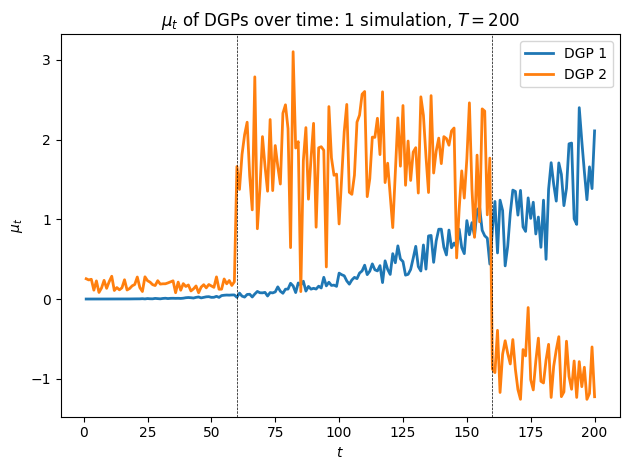

In [101]:
T = 200
plt.plot(np.arange(1, T + 1), mu1, linewidth=2, label='DGP 1')
plt.plot(np.arange(1, T + 1), mu2, linewidth=2, label='DGP 2')



plt.xlabel(r"$t$")
plt.ylabel(r"$\mu_t$")
plt.axvline(0.8*T, linestyle="--", color="black",linewidth=0.5) 
plt.axvline(0.3*T, linestyle="--", color="black",linewidth=0.5)
plt.title(r"$\mu_t$ of DGPs over time: 1 simulation, $T=200$")
plt.legend()
plt.tight_layout()
plt.show()

Methodology: Estimator

c = 0.33: θ_j falls below tolerance=1e-03 at j = 24
c = 0.68: θ_j falls below tolerance=1e-03 at j = 35
c = 1.00: θ_j falls below tolerance=1e-03 at j = 42
c = 1.53: θ_j falls below tolerance=1e-03 at j = 52
c = 3.00: θ_j falls below tolerance=1e-03 at j = 73


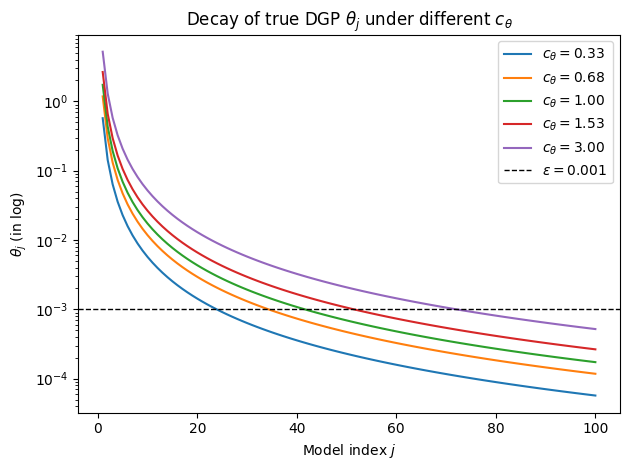

In [68]:
def check_true_dgp(alpha=1.5, eps=1e-3):
    j = np.arange(1, 101)
    # c values implied by R^2 in [0.1, 0.9]
    cs = [0.33, 0.68, 1.00, 1.53, 3.00]

    for c in cs:
        theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))
        # find first index where theta_j <= eps since theta is monotonically decreasing
        fail_idx = np.where(theta <= eps)[0]

        if len(fail_idx) == 0:
            print(f"c = {c:.2f}: θ_j remains above tolerance={eps:.0e} for all j ≤ {j[-1]}")
        else:
            j_star = j[fail_idx[0]]
            print(f"c = {c:.2f}: θ_j falls below tolerance={eps:.0e} at j = {j_star}")
        plt.plot(j, theta, label=fr"$c_{{\theta}} = {c:.2f}$")
    plt.axhline(eps, color="black", linestyle="--", linewidth=1, label=fr"$\varepsilon = {eps}$")
    plt.xlabel(r"Model index $j$")
    plt.ylabel(r"$\theta_j$ (in log)")
    plt.title(r"Decay of true DGP $\theta_j$ under different $c_{\theta}$")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()
check_true_dgp()

In [9]:
def ls_oracle_mse(mu_hat_mat, mu_true):

    M = mu_hat_mat.shape[1]

    def obj(w):
        mu_w = mu_hat_mat @ w
        return np.mean((mu_w - mu_true)**2)

    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w}
    )

    w0 = np.full(M, 1.0 / M)
    res = minimize(obj, w0, constraints=cons, method='SLSQP')
    mu_oracle = mu_hat_mat @ res.x

    return np.mean((mu_oracle - mu_true)**2)


In [10]:

def kernel_vec(t, T, h):
    s = np.arange(1, T + 1) # Epanechnikov
    u = (s - t) / (T * h)
    k = 0.75 * (1 - u**2)
    k[np.abs(u) > 1] = 0.0
    return k

def local_jackknife(Y, X, h):
    T = len(Y); mu_tilde = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        K[i] = 0.0
        W = np.diag(K)
        beta = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)
        mu_tilde[i] = X[i, :] @ beta
    return mu_tilde

def local_estimator(Y, X, h):
    T = len(Y); mu_hat = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        # K[i] = 0.0
        W = np.diag(K)
        beta = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)
        mu_hat[i] = X[i, :] @ beta
    return mu_hat

def obj_cv(w, mu_mat, Y, K):
    mu_w = mu_mat @ w
    resid = Y - mu_w
    return np.sum(resid**2 * K)

def tvjma(Y, X_list, h):
    T, M = len(Y), len(X_list)
    # Local estimator
    mu_hat_mat = np.empty((T, M))
    for m, X in enumerate(X_list):
        mu_hat_mat[:, m] = local_estimator(Y, X, h)
    # Jackknife Prediction
    mu_tilde_mat = np.empty((T, M))
    for m, X in enumerate(X_list):
        mu_tilde_mat[:, m] = local_jackknife(Y, X, h)

    # Optimization for time varying weights with kernel fct & obj_cv (with mu tilde)
    w_hat = np.zeros((T, M)); mu_hat = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        # K[i] = 0.0
        cons = ({'type':'eq','fun':lambda w: np.sum(w)-1},
                {'type':'ineq','fun':lambda w: w})
        w0 = np.full(M, 1./M) # initial value = uniform
        res = minimize(obj_cv, w0, args=(mu_tilde_mat, Y, K),
                       method='SLSQP', constraints=cons,
                       options={'ftol':1e-9})
        w_hat[i] = res.x
        mu_hat[i] = mu_hat_mat[i] @ w_hat[i]
    return mu_hat, mu_hat_mat, mu_tilde_mat, w_hat

def build_X_list(X):
    T, J = X.shape
    X_list = []

    for m in range(1, J + 1):
        X_list.append(X[:, :m])

    return X_list


def monte_carlo(T, R2, dgp_num, ch, n_rep=1000):
    MSE_inf_all = []   # will store lowest MSE across candidate models per replication
    MSE_tvjma_all = []    # will store MSE of TVJMA per replication
    J = int(np.round(3 * T**(1/3)))
    h = ch * T**(-0.2)

    for r in (range(n_rep)):
        if dgp_num == 1:
            Y, X, mu_true = DGP1(T, 100, R2)
        elif dgp_num == 2:
            Y, X, mu_true = DGP2(T, 100, R2)
        else:
            raise ValueError("dgp must be 'DGP1' or 'DGP2'")

        X = X[:, :J]
        X_list = build_X_list(X)
        mu_tvma, mu_hat_mat, mu_tilde_mat, w_hat = tvjma(Y, X_list, h)

        M = len(X_list)
        mu_hat_ls = np.empty((T, M))

        for m, Xm in enumerate(X_list):
            beta_ls = np.linalg.lstsq(Xm, Y, rcond=None)[0]
            mu_hat_ls[:, m] = Xm @ beta_ls

        mse_oracle = ls_oracle_mse(mu_hat_ls, mu_true)
        MSE_inf_all.append(mse_oracle)

            # TVJMA risk
        mse_tvjma = np.mean((mu_tvma - mu_true)**2)
        MSE_tvjma_all.append(mse_tvjma)

    # Convert to numpy arrays
    MSE_inf_all = np.array(MSE_inf_all)
    MSE_tvjma_all = np.array(MSE_tvjma_all)

    normalized_risk = MSE_tvjma_all.mean() / MSE_inf_all.mean()

    return normalized_risk, MSE_tvjma_all/MSE_inf_all


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


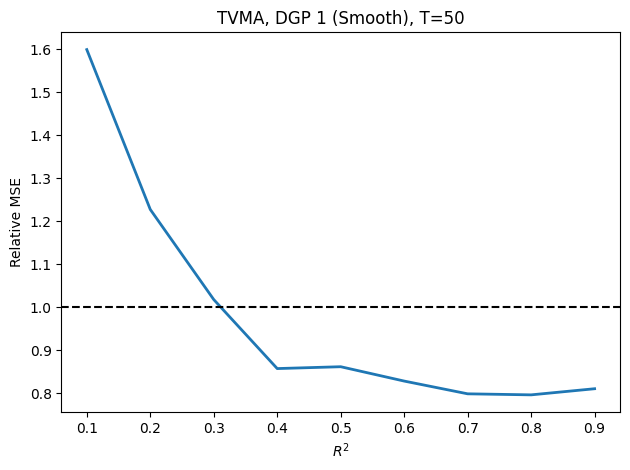

In [11]:

T = 50
rel_mse = np.zeros(len(R2_grid))
mse = []
mse_tvjma = []

for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse[i], mse = monte_carlo(T, R2, dgp_num = 1,  ch= 2.34, n_rep=100)
    mse_tvjma.append(mse)

plt.plot(R2_grid, rel_mse, linewidth=2)
plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"TVMA, DGP 1 (Smooth), T={T}")
plt.tight_layout()
plt.show()

In [12]:
# np.savetxt("partI_rel_mse_t50_dgp1.csv", rel_mse, delimiter=",")

# Part II. Code extension

#### When T=200, the optimal bandwidth is ...

In [13]:
# DGP 1 and T=200
T= 200 
rel_mse_1s_T200 = np.zeros(len(R2_grid))
rel_mse_1m_T200 = np.zeros(len(R2_grid))
rel_mse_1l_T200 = np.zeros(len(R2_grid))
rel_mse_1opt_T200 = np.zeros(len(R2_grid))
mse_temp=[]
mse_1s_T200 = []
mse_1m_T200 = []
mse_1l_T200 = []
mse_1opt_T200 = []

In [14]:
h_test=0.3
ch_test=h_test/T**(-0.2)
print(f"$c_h$ for simulation = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1s_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test, n_rep=100)
    mse_1s_T200.append(mse_temp)


$c_h$ for simulation = 0.866


100%|██████████| 9/9 [11:11<00:00, 74.61s/it]


In [15]:
h_test=0.5
ch_test2=h_test/T**(-0.2)
print(f"$c_h$ for simulation = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1m_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test2, n_rep=100)
    mse_1m_T200.append(mse_temp)


$c_h$ for simulation = 0.866


100%|██████████| 9/9 [11:10<00:00, 74.51s/it]


In [16]:
h_test=0.9
ch_test3=h_test/T**(-0.2)
print(f"$c_h$ for simulation = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1l_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test3, n_rep=100)
    mse_1l_T200.append(mse_temp)

$c_h$ for simulation = 0.866


100%|██████████| 9/9 [11:09<00:00, 74.43s/it]


In [17]:
print(f"$c_h$ for simulation = {np.round(ch_opt, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1opt_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_opt, n_rep=100)
    mse_1opt_T200.append(mse_temp)

$c_h$ for simulation = 2.34


100%|██████████| 9/9 [11:06<00:00, 74.04s/it]


In [18]:
np.savetxt("rel_mse_1s_T200.csv", rel_mse_1s_T200, delimiter=",")
np.savetxt("rel_mse_1m_T200.csv", rel_mse_1m_T200, delimiter=",")
np.savetxt("rel_mse_1l_T200.csv", rel_mse_1l_T200, delimiter=",")
np.savetxt("rel_mse_1opt_T200.csv", rel_mse_1opt_T200, delimiter=",")
np.savetxt("mse_1s_T200.csv", mse_1s_T200, delimiter=",")
np.savetxt("mse_1m_T200.csv", mse_1m_T200, delimiter=",")
np.savetxt("mse_1l_T200.csv", mse_1l_T200, delimiter=",")
np.savetxt("mse_1opt_T200.csv", mse_1opt_T200, delimiter=",")

/tmp/ipykernel_76/144169825.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_1opt_T200,


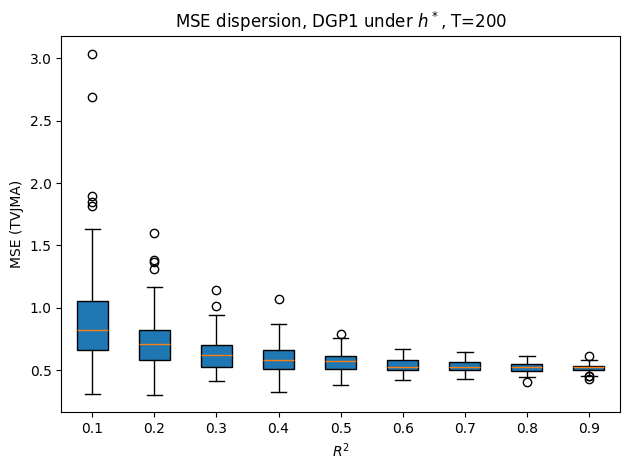

In [77]:
plt.boxplot(mse_1opt_T200,
            labels=[f"{r2:.1f}" for r2 in R2_grid],
            showfliers=True, patch_artist=True)
plt.xlabel(r"$R^2$")
plt.ylabel("MSE (TVJMA)")
plt.title(f"MSE dispersion, DGP1 under $h^*$, T={T}")
plt.tight_layout()
plt.show()



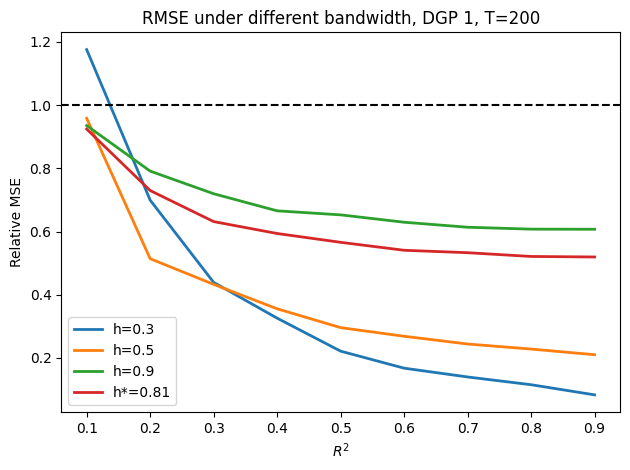

In [76]:
plt.plot(R2_grid, rel_mse_1s_T200, linewidth=2, label='h=0.3')
plt.plot(R2_grid, rel_mse_1m_T200, linewidth=2, label='h=0.5')
plt.plot(R2_grid, rel_mse_1l_T200, linewidth=2, label='h=0.9')
plt.plot(R2_grid, rel_mse_1opt_T200, linewidth=2, label='h*=0.81')

plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"RMSE under different bandwidth, DGP 1, T={T}")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:

# data = [mu_1s, mu_1m,, mu_1l, mu_1opt]
# labels = ['h=0.3', 'h=0.5', 'h=0.9', 'h*=0.81']

# plt.figure()
# plt.boxplot(data, labels=labels, showfliers=True)
# plt.ylabel("Mu at time T=26")
# plt.title(f"TVMA, DGP 1 (Smooth Structural Changes), T={T}")
# plt.tight_layout()
# plt.show()

#### When T=50, the optimal bandwidth is...

In [22]:
# DGP 1 and T=50
T= 50
rel_mse_1s_T50 = np.zeros(len(R2_grid))
rel_mse_1m_T50 = np.zeros(len(R2_grid))
rel_mse_1l_T50 = np.zeros(len(R2_grid))
rel_mse_1opt_T50 = np.zeros(len(R2_grid))

mse_1s_T50 = []
mse_1m_T50 = []
mse_1l_T50 = []
mse_1opt_T50 = []

In [23]:

h_test=T**(-0.2) * ch_test
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1s_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test, n_rep=100)
    mse_1s_T50.append(mse_temp)


$h$ for simulation = 0.3958523732318683 with ch = 0.866


100%|██████████| 9/9 [01:23<00:00,  9.31s/it]


In [24]:

h_test=T**(-0.2) * ch_test2
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test2, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1m_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test2, n_rep=100)
    mse_1m_T50.append(mse_temp)


$h$ for simulation = 0.6597539553864472 with ch = 1.443


100%|██████████| 9/9 [01:20<00:00,  8.97s/it]


In [25]:

h_test=T**(-0.2) * ch_test3
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test3, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1l_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_test3, n_rep=100)
    mse_1l_T50.append(mse_temp)
	

$h$ for simulation = 1.1875571196956047 with ch = 2.597


100%|██████████| 9/9 [01:19<00:00,  8.80s/it]


In [26]:
print(f"$c_h$ for simulation = {np.round(ch_opt, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_1opt_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=1, ch=ch_opt, n_rep=100)
    mse_1opt_T50.append(mse_temp)

$c_h$ for simulation = 2.34


100%|██████████| 9/9 [01:20<00:00,  8.97s/it]


In [27]:
np.savetxt("rel_mse_1s_T50.csv", rel_mse_1s_T50, delimiter=",")
np.savetxt("rel_mse_1m_T50.csv", rel_mse_1m_T50, delimiter=",")
np.savetxt("rel_mse_1l_T50.csv", rel_mse_1l_T50, delimiter=",")
np.savetxt("rel_mse_1opt_T50.csv", rel_mse_1opt_T50, delimiter=",")
np.savetxt("mse_1s_T50.csv", mse_1s_T50, delimiter=",")
np.savetxt("mse_1m_T50.csv", mse_1m_T50, delimiter=",")
np.savetxt("mse_1l_T50.csv", mse_1l_T50, delimiter=",")
np.savetxt("mse_1opt_T50.csv", mse_1opt_T50, delimiter=",")

/tmp/ipykernel_76/2386974399.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_1opt_T50,


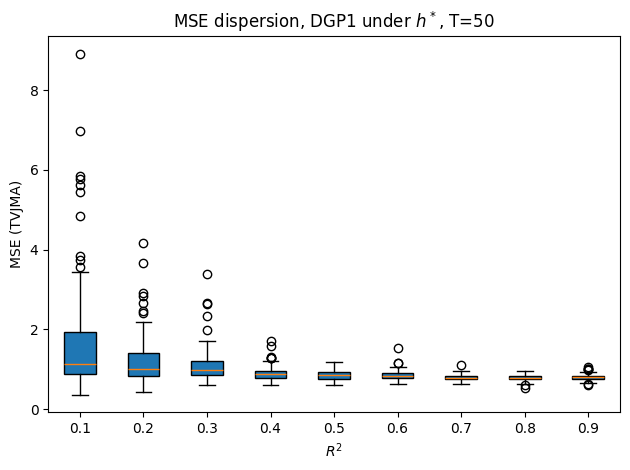

In [121]:
T=50
plt.boxplot(mse_1opt_T50,
            labels=[f"{r2:.1f}" for r2 in R2_grid],
            showfliers=True, patch_artist=True)
plt.xlabel(r"$R^2$")
plt.ylabel("MSE (TVJMA)")
plt.title(f"MSE dispersion, DGP1 under $h^*$, T={T}")
plt.tight_layout()
plt.show()



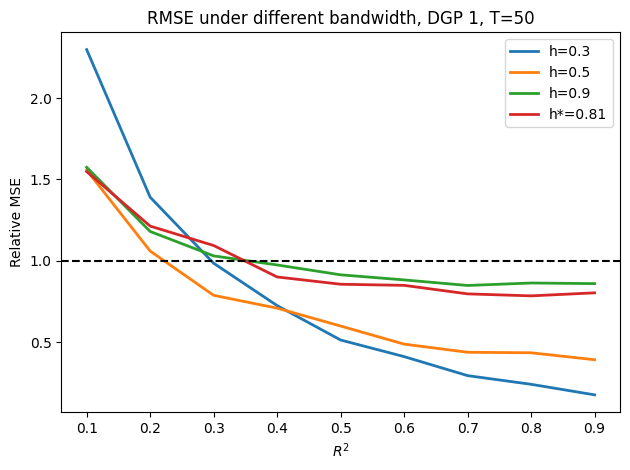

In [122]:
T=50
plt.plot(R2_grid, rel_mse_1s_T50, linewidth=2, label='h=0.3')
plt.plot(R2_grid, rel_mse_1m_T50, linewidth=2, label='h=0.5')
plt.plot(R2_grid, rel_mse_1l_T50, linewidth=2, label='h=0.9')
plt.plot(R2_grid, rel_mse_1opt_T50, linewidth=2, label='h*=0.81')

plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"RMSE under different bandwidth, DGP 1, T={T}")
plt.legend()
plt.tight_layout()
plt.show()

**The optimal bandwidth is subject to the size of samples, T!**

 #### The bandwidth choice is also sensitive to the different DGP

When T=50,

In [30]:
# DGP 2 and T=50
T= 50
rel_mse_2s_T50 = np.zeros(len(R2_grid))
rel_mse_2m_T50 = np.zeros(len(R2_grid))
rel_mse_2l_T50 = np.zeros(len(R2_grid))
rel_mse_2opt_T50 = np.zeros(len(R2_grid))

mse_2s_T50 = []
mse_2m_T50 = []
mse_2l_T50 = []
mse_2opt_T50 = []

In [31]:

h_test=T**(-0.2) * ch_test
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2s_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test, n_rep=100)
    mse_2s_T50.append(mse_temp)


$h$ for simulation = 0.3958523732318683 with ch = 0.866


100%|██████████| 9/9 [01:25<00:00,  9.52s/it]


In [32]:

h_test=T**(-0.2) * ch_test2
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test2, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2m_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test2, n_rep=100)
    mse_2m_T50.append(mse_temp)


$h$ for simulation = 0.6597539553864472 with ch = 1.443


100%|██████████| 9/9 [01:21<00:00,  9.03s/it]


In [33]:

h_test=T**(-0.2) * ch_test3
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test3, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2l_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test3, n_rep=100)
    mse_2l_T50.append(mse_temp)
	

$h$ for simulation = 1.1875571196956047 with ch = 2.597


100%|██████████| 9/9 [01:20<00:00,  8.98s/it]


In [34]:
print(f"$c_h$ for simulation = {np.round(ch_opt, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2opt_T50[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_opt, n_rep=100)
    mse_2opt_T50.append(mse_temp)

$c_h$ for simulation = 2.34


100%|██████████| 9/9 [01:19<00:00,  8.80s/it]


In [82]:
np.savetxt("rel_mse_2s_T50.csv", rel_mse_2s_T50, delimiter=",")
np.savetxt("rel_mse_2m_T50.csv", rel_mse_2m_T50, delimiter=",")
np.savetxt("rel_mse_2l_T50.csv", rel_mse_2l_T50, delimiter=",")
np.savetxt("rel_mse_2opt_T50.csv", rel_mse_2opt_T50, delimiter=",")
np.savetxt("mse_2s_T50.csv", mse_2s_T50, delimiter=",")
np.savetxt("mse_2m_T50.csv", mse_2m_T50, delimiter=",")
np.savetxt("mse_2l_T50.csv", mse_2l_T50, delimiter=",")
np.savetxt("mse_2opt_T50.csv", mse_2opt_T50, delimiter=",")


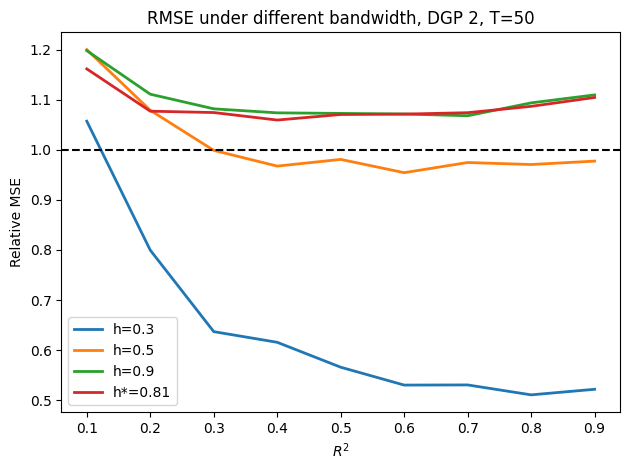

In [87]:
plt.plot(R2_grid, rel_mse_2s_T50, linewidth=2, label='h=0.3')
plt.plot(R2_grid, rel_mse_2m_T50, linewidth=2, label='h=0.5')
plt.plot(R2_grid, rel_mse_2l_T50, linewidth=2, label='h=0.9')
plt.plot(R2_grid, rel_mse_2opt_T50, linewidth=2, label='h*=0.81')

plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"RMSE under different bandwidth, DGP 2, T={T}")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_76/536797711.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_2opt_T50,


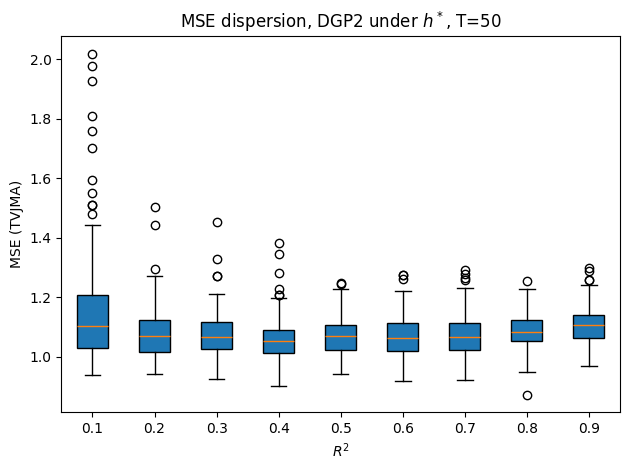

In [88]:

plt.boxplot(mse_2opt_T50,
            labels=[f"{r2:.1f}" for r2 in R2_grid],
            showfliers=True, patch_artist=True)
plt.xlabel(r"$R^2$")
plt.ylabel("MSE (TVJMA)")
plt.title(f"MSE dispersion, DGP2 under $h^*$, T={T}")
plt.tight_layout()
plt.show()

When T=200,

In [38]:
# DGP 2 and T=200
T= 200
rel_mse_2s_T200 = np.zeros(len(R2_grid))
rel_mse_2m_T200 = np.zeros(len(R2_grid))
rel_mse_2l_T200 = np.zeros(len(R2_grid))
rel_mse_2opt_T200 = np.zeros(len(R2_grid))

mse_2s_T200 = []
mse_2m_T200 = []
mse_2l_T200 = []
mse_2opt_T200 = []

In [39]:

h_test=T**(-0.2) * ch_test
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2s_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test, n_rep=100)
    mse_2s_T200.append(mse_temp)


$h$ for simulation = 0.3 with ch = 0.866


100%|██████████| 9/9 [11:31<00:00, 76.80s/it]


In [40]:

h_test=T**(-0.2) * ch_test2
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test2, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2m_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test2, n_rep=100)
    mse_2m_T200.append(mse_temp)


$h$ for simulation = 0.5 with ch = 1.443


100%|██████████| 9/9 [11:53<00:00, 79.27s/it]


In [41]:

h_test=T**(-0.2) * ch_test3
print(f"$h$ for simulation = {h_test} with ch = {np.round(ch_test3, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2l_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_test3, n_rep=100)
    mse_2l_T200.append(mse_temp)
	

$h$ for simulation = 0.8999999999999999 with ch = 2.597


100%|██████████| 9/9 [11:56<00:00, 79.65s/it]


In [42]:
print(f"$c_h$ for simulation = {np.round(ch_opt, 3)}")
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_2opt_T200[i], mse_temp = monte_carlo(T, R2, dgp_num=2, ch=ch_opt, n_rep=100)
    mse_2opt_T200.append(mse_temp)

$c_h$ for simulation = 2.34


100%|██████████| 9/9 [11:51<00:00, 79.02s/it]


In [43]:
np.savetxt("rel_mse_2s_T200.csv", rel_mse_2s_T200, delimiter=",")
np.savetxt("rel_mse_2m_T200.csv", rel_mse_2m_T200, delimiter=",")
np.savetxt("rel_mse_2l_T200.csv", rel_mse_2l_T200, delimiter=",")
np.savetxt("rel_mse_2opt_T200.csv", rel_mse_2opt_T200, delimiter=",")
np.savetxt("mse_2s_T200.csv", mse_2s_T200, delimiter=",")
np.savetxt("mse_2m_T200.csv", mse_2m_T200, delimiter=",")
np.savetxt("mse_2l_T200.csv", mse_2l_T200, delimiter=",")
np.savetxt("mse_2opt_T200.csv", mse_2opt_T200, delimiter=",")

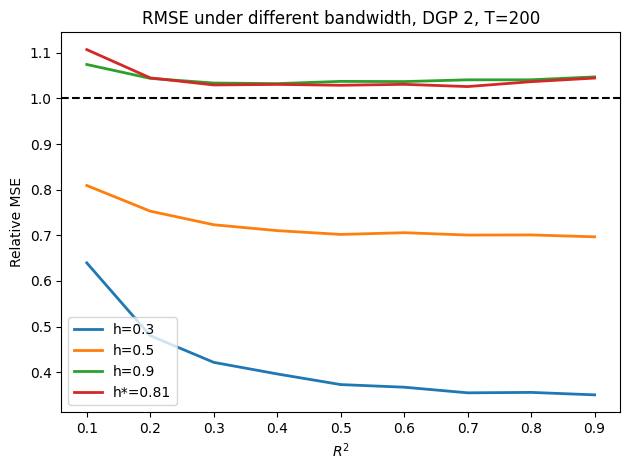

In [124]:
plt.plot(R2_grid, rel_mse_2s_T200, linewidth=2, label='h=0.3')
plt.plot(R2_grid, rel_mse_2m_T200, linewidth=2, label='h=0.5')
plt.plot(R2_grid, rel_mse_2l_T200, linewidth=2, label='h=0.9')
plt.plot(R2_grid, rel_mse_2opt_T200, linewidth=2, label='h*=0.81')

plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"RMSE under different bandwidth, DGP 2, T={T}")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_76/149930678.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_2opt_T200,


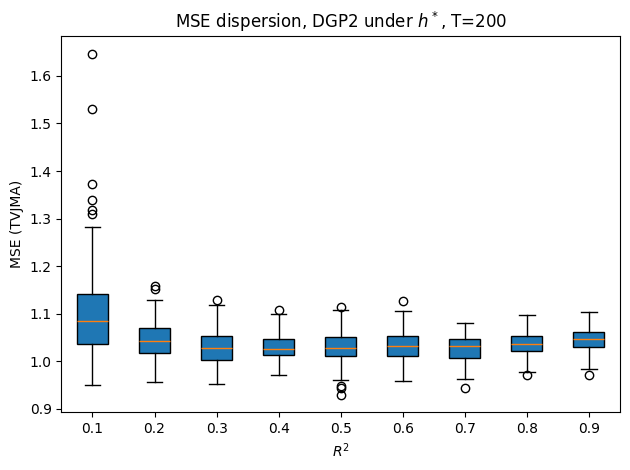

In [123]:
T=200
plt.boxplot(mse_2opt_T200,
            labels=[f"{r2:.1f}" for r2 in R2_grid],
            showfliers=True, patch_artist=True)
plt.xlabel(r"$R^2$")
plt.ylabel("MSE (TVJMA)")
plt.title(f"MSE dispersion, DGP2 under $h^*$, T={T}")
plt.tight_layout()
plt.show()

In [96]:
def plot_mu_paths(T, R2, dgp_num, ch_list, labels, seed=2026):
    np.random.seed(seed)

    # Generate one dataset
    if dgp_num == 1:
        Y, X, mu_true = DGP1(T, 100, R2)
        dgp_name = "DGP 1"
    else:
        Y, X, mu_true = DGP2(T, 100, R2)
        dgp_name = "DGP 2"

    J = int(np.round(3 * T**(1/3)))
    X = X[:, :J]
    X_list = build_X_list(X)

    tgrid = np.arange(1, T + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(tgrid, mu_true, color="black", linewidth=2.5, label="True $\\mu_t$")

    # Loop over bandwidths
    for ch, lab in zip(ch_list, labels):
        h = ch * T**(-0.2)
        mu_hat, _, _, _ = tvjma(Y, X_list, h)
        plt.plot(tgrid, mu_hat, linewidth=1.5, label=lab)

    # Structural break lines for DGP 2
    if dgp_num == 2:
        plt.axvline(0.3 * T, color="gray", linestyle="--", linewidth=1)
        plt.axvline(0.8 * T, color="gray", linestyle="--", linewidth=1)

    plt.xlabel(r"$t$")
    plt.ylabel(r"$\mu_t$")
    plt.title(f"TVJMA mean paths — {dgp_name}, $T={T}$, $R^2={R2}$")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("mu_paths_DGP1_T200_R2_05.png")
    plt.show()

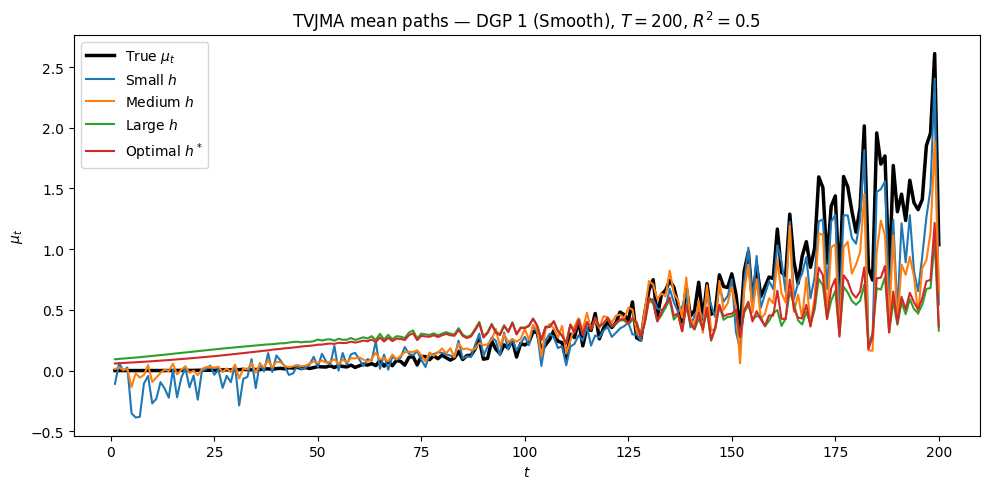

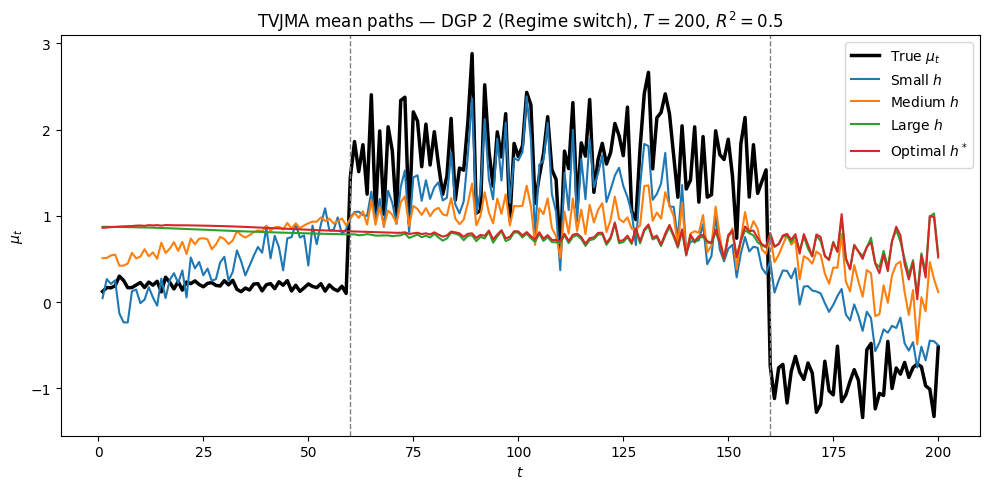

In [90]:
T = 200
R2 = 0.5

ch_list = [
    ch_test,     # corresponds to h ≈ 0.3
    ch_test2,    # corresponds to h ≈ 0.5
    ch_test3,    # corresponds to h ≈ 0.9
    ch_opt       # optimal bandwidth
]

labels = [
    "Small $h$",
    "Medium $h$",
    "Large $h$",
    "Optimal $h^*$"
]

plot_mu_paths(T, R2, dgp_num=1, ch_list=ch_list, labels=labels)
plot_mu_paths(T, R2, dgp_num=2, ch_list=ch_list, labels=labels)


In [117]:

def plot_avg_weights(T, R2, dgp_num, ch_list, labels, seed=2026):
    np.random.seed(seed)

    if dgp_num == 1:
        Y, X, _ = DGP1(T, 100, R2)
        dgp_name = "DGP 1"
    else:
        Y, X, _ = DGP2(T, 100, R2)
        dgp_name = "DGP 2"

    M = int(np.round(3 * T**(1/3)))

    X = X[:, :M]
    X_list = build_X_list(X)

    plt.figure(figsize=(8, 5))

    for ch, lab in zip(ch_list, labels):
        h = ch * T**(-0.2)
        _, _, _, w_hat = tvjma(Y, X_list, h)
        avg_w = w_hat.mean(axis=0)

        x = np.arange(1, M + 1)
        plt.plot(x, avg_w, linewidth=2, label=lab)

    plt.xlabel("Model index $j$", fontsize=12)
    plt.ylabel("Average weight", fontsize=12)

    plt.xticks(np.arange(1, M + 1))


    plt.title(f"Average TVJMA Weights, {dgp_name}, $T={T}$, $R^2={R2}$", fontsize=13)
    plt.legend()
    plt.tight_layout()
    plt.show()


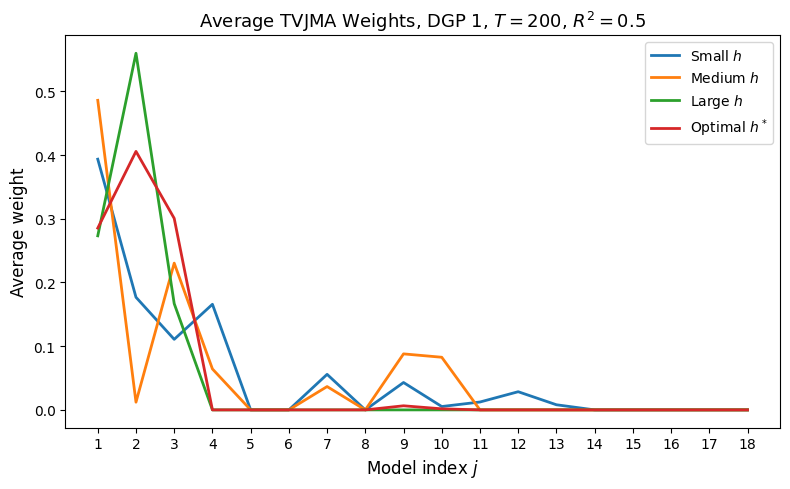

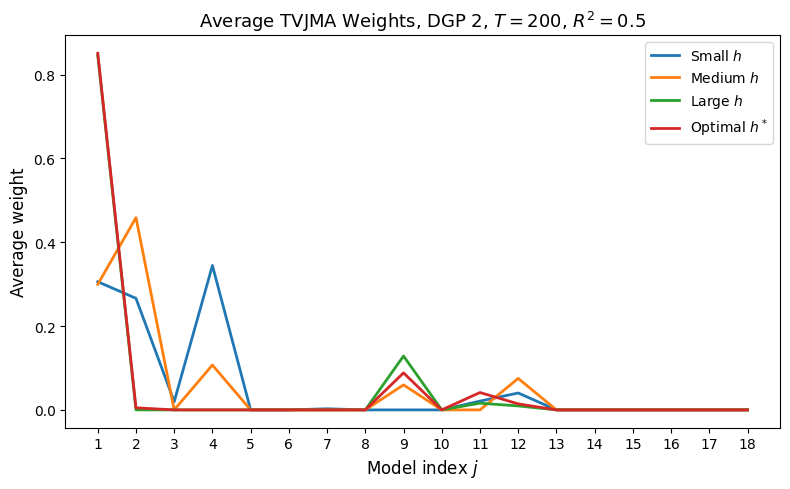

In [118]:

T = 200
R2 = 0.5

plot_avg_weights(T, R2, dgp_num=1, ch_list=ch_list, labels=labels)
plot_avg_weights(T, R2, dgp_num=2, ch_list=ch_list, labels=labels)


### Appendix

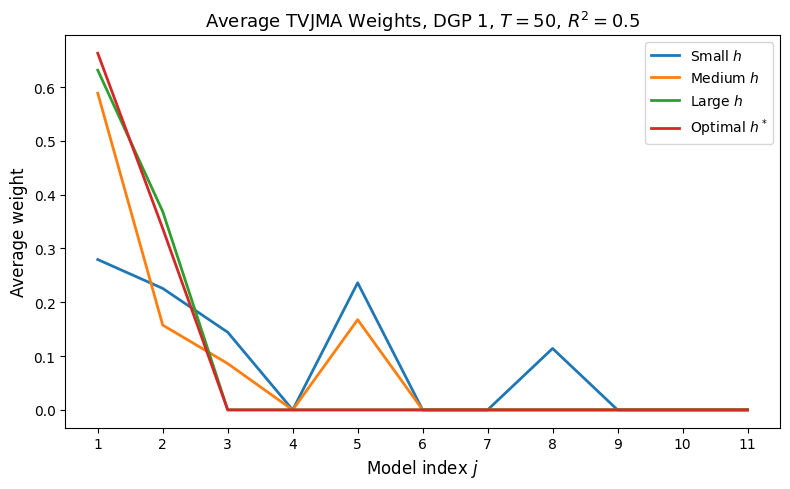

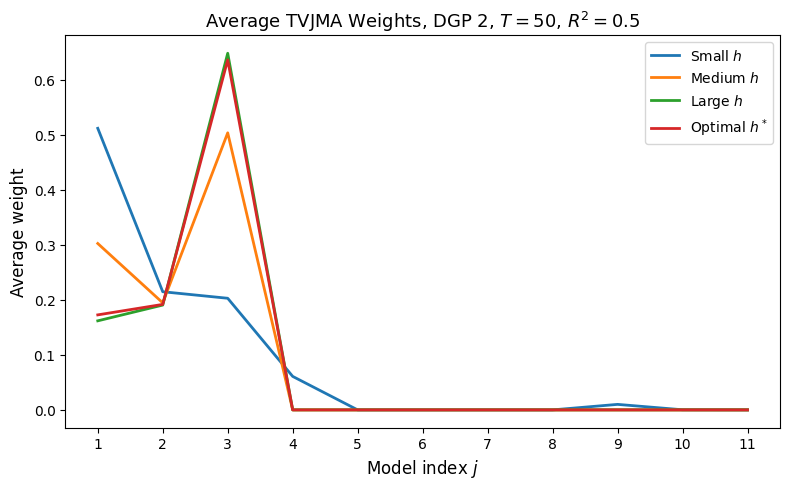

In [120]:

T = 50
R2 = 0.5

plot_avg_weights(T, R2, dgp_num=1, ch_list=ch_list, labels=labels)
plot_avg_weights(T, R2, dgp_num=2, ch_list=ch_list, labels=labels)


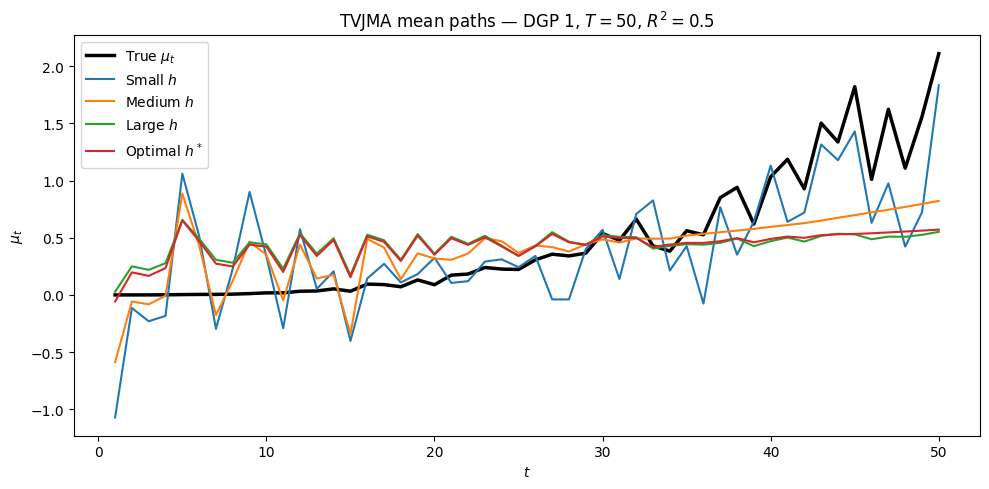

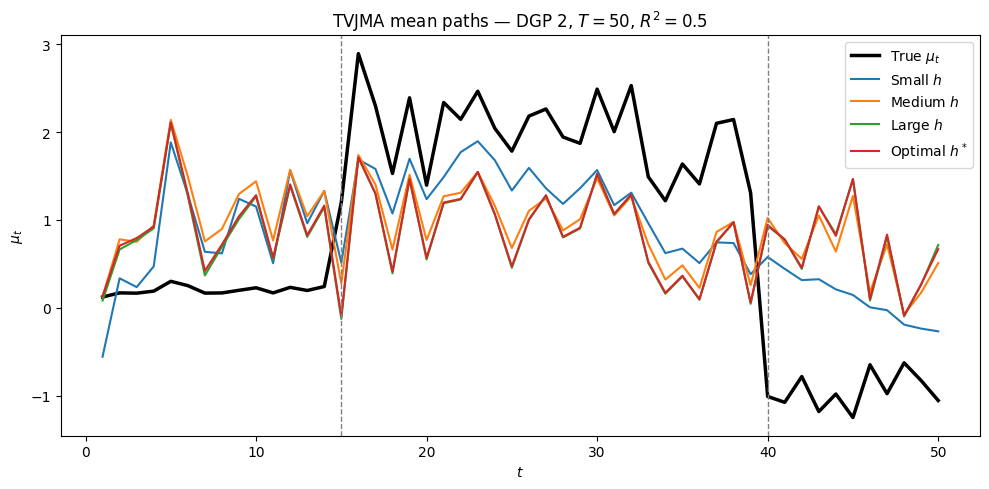

In [97]:
T = 50
R2 = 0.5

ch_list = [
    ch_test,     # corresponds to h ≈ 0.3
    ch_test2,    # corresponds to h ≈ 0.5
    ch_test3,    # corresponds to h ≈ 0.9
    ch_opt       # optimal bandwidth
]

labels = [
    "Small $h$",
    "Medium $h$",
    "Large $h$",
    "Optimal $h^*$"
]

plot_mu_paths(T, R2, dgp_num=1, ch_list=ch_list, labels=labels)
plot_mu_paths(T, R2, dgp_num=2, ch_list=ch_list, labels=labels)
